In [481]:
import sys
sys.path.append("../")

from transformers import AutoTokenizer
from models.clip import CLIPTextTransformer, CLIPVisionTransformer, CLIPModel

In [482]:
from transformers import FlaxCLIPModel, AutoProcessor, AutoTokenizer

model = FlaxCLIPModel.from_pretrained("openai/clip-vit-base-patch16")
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch16")

In [483]:
import jax.numpy as np

In [484]:
import optax 
from flax.training import checkpoints, common_utils, train_state

import flax

replicate = flax.jax_utils.replicate
unreplicate = flax.jax_utils.unreplicate

schedule = optax.warmup_cosine_decay_schedule(
    init_value=0.0,
    peak_value=1e-4,
    warmup_steps=5_000,
    decay_steps=100_000,
)

tx = optax.adamw(learning_rate=schedule, weight_decay=1e-4)
state = train_state.TrainState.create(apply_fn=model.__call__, params=model.params, tx=tx)
pstate = replicate(state)

In [485]:
import yaml
from ml_collections.config_dict import ConfigDict

logging_dir = '../logging/proposals/'

run_name = 'deep-monkey-87'
# run_name = 'ancient-armadillo-88'
# run_name = 'faithful-river-68'  # No crops
# run_name = 'zesty-morning-85'  # New run

config_file = "{}/{}/config.yaml".format(logging_dir, run_name)

with open(config_file, 'r') as file:
    config = yaml.safe_load(file)
    
config = ConfigDict(config)

In [487]:
# ckpt_dir = "{}/{}/".format(logging_dir, run_name)  # Load SLURM run
# restored_state = checkpoints.restore_checkpoint(ckpt_dir=ckpt_dir, target=state)

# if state is restored_state:
#     raise FileNotFoundError(f"Did not load checkpoint correctly")

In [488]:
restored_state = state

In [489]:
from models.dataset_utils import make_dataloader, create_input_iter
import tensorflow as tf

files = tf.io.gfile.glob(f"../data/tfrecords_v3/*val*.tfrecord")

ds = make_dataloader(files, batch_size=config.training.batch_size, seed=config.seed, split="val", shuffle=False)
batches = iter(ds)

In [490]:
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch16")

In [491]:
from dm_pix import center_crop

In [492]:
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    similarity = dot_product / (norm_vec1 * norm_vec2)
    return similarity

## Zero-shot classification

In [493]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/astrothesaurus/UAT/master/UAT.csv", "data/UAT.csv")

('data/UAT.csv', <http.client.HTTPMessage at 0x144ff6ad7f40>)

In [494]:
import csv

concepts = []

with open('data/UAT.csv') as f:
    reader = csv.reader(f) 
    next(reader)

    for row in reader:
        text = []
        for level in row:
            if level:
                text.append(level)
        concepts.append(', '.join(text))

In [495]:
import jax.numpy as np

images, captions = next(batches)
images = np.array(images)
captions = captions.numpy().tolist()
captions = [c.decode('utf-8') for c in captions]

In [496]:
images = center_crop(images, 224, 224)
inputs_images = processor(text=captions, images=(images * 255.), return_tensors="np", padding="max_length", truncation=False, max_length=77)

In [497]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle

# claude_science_cat =  ["star forming galaxies", "lyman alpha", "sfr", "dust", "crowded stellar field", "core-collapse supernova", "cosmology",  "gravitational lensing", "supernovae", "diffuse galaxies", "globular clusters", "stellar populations", "interstellar medium", "black holes", "dark matter", "galaxy clusters", "galaxy evolution", "galaxy formation", "quasars", "circumstellar disks", "exoplanets", "Kuiper Belt objects", "solar system objects", "cosmic web structure", "distant galaxies", "galaxy mergers", "galaxy interactions", "star formation", "stellar winds", "brown dwarfs", "neutron stars", "white dwarfs", "nebulae", "star clusters", "galaxy archeology", "galactic structure", "active galactic nuclei", "gamma-ray bursts", "stellar nurseries", "intergalactic medium", "galaxy clusters", "dark energy", "dwarf galaxies", "barred spiral galaxies", "irregular galaxies", "starburst galaxies", "dwarf galaxies", "low surface brightness galaxies", "ultra diffuse galaxies", "circumgalactic medium", "intracluster medium", "cosmic dust", "interstellar chemistry", "star formation histories", "initial mass function", "mass segregation", "stellar proper motions", "binary star systems", "open clusters", "pre-main sequence stars", "protostars", "protoplanetary disks", "jets and outflows", "interstellar shocks", "HII regions", "planetary nebulae", "supernova remnants", "stellar winds", "red giants", "Cepheid variables", "RR Lyrae variables", "stellar oscillations", "stellar abundances", "stellar rotation", "stellar magnetic fields", "stellar dynamics", "compact stellar remnants", "Einstein rings", "asteroids", "comets", "trans-Neptunian objects", "cosmic microwave background", "reionization epoch", "first stars", "first galaxies", "high-redshift quasars", "primordial black holes", "resolved binaries", "binary stars"]
claude_science_cat =  ['Galaxies', 'Galaxy Clusters', 'Gravitational Lensing', 'Active Galactic Nuclei', 'Quasars', 'Supernovae', 'Star Formation Regions', 'Nebulae', 'Stellar Populations', 'Binary Stars', 'Exoplanets', 'Kuiper Belt Objects', 'Oort Cloud Objects', 'Asteroids', 'Comets', 'Globular Clusters', 'Open Clusters', 'Interacting Galaxies', 'Merging Galaxies', 'Spiral Galaxies', 'Elliptical Galaxies', 'Irregular Galaxies', 'Dwarf Galaxies', 'Galaxy Morphology', 'Galaxy Structure', 'Galactic Nuclei', 'Bulges', 'Disks', 'Halos', 'Spiral Arms', 'Bars', 'Tidal Tails', 'Stellar Streams', 'Ultraviolet Imaging', 'Optical Imaging', 'Infrared Imaging', 'Emission Line Imaging', 'Absorption Line Imaging', 'Spectroscopy', 'Photometry', 'High Redshift Galaxies', 'Cosmic Web', 'Voids', 'Large Scale Structure', 'Dark Matter Mapping', 'Cooling Flows', 'Galaxy Rotation Curves', 'Tidal Interactions', 'Ram Pressure Stripping', 'Galaxy Outflows', 'Shock Fronts', 'Radio Jets', 'Bow Shocks', 'X-ray Emission', 'Radio Emission', 'Molecular Gas', 'Atomic Gas', 'Dust Lanes', 'Dust Extinction', 'Dust Emission', 'Stellar Populations', 'Stellar Dynamics', 'Mass Profiles', 'Black Holes', 'Supernova Progenitors', 'Stellar Associations', 'H II Regions', 'Planetary Nebulae', 'Emission Line Ratios', 'Wolf-Rayet Stars', 'Luminous Blue Variables', 'Red Supergiants', 'Cepheids', 'Surface Brightness Fluctuations', 'Tidal Dwarf Galaxies', 'Ultra-diffuse Galaxies', 'Dwarf Spheroidals', 'Ultracompact Dwarfs', 'Globular Clusters', 'Planetary Nebulae', 'Supernova Remnants', 'Pulsar Wind Nebulae', 'Lyman-alpha Emitters', 'Gamma-ray Bursts', 'Tidal Disruption Events', 'Microlensing Events', 'Caustics', 'Einstein Rings', 'Arcs', 'Multiple Images', 'Strong Lensing', 'Weak Lensing', 'Shear Mapping', 'Magnification Mapping', 'Time Delays', 'Macrolensing', 'Microlensing', 'Astrometry', 'Proper Motions', 'Parallaxes', 
                      'Dark Matter', 'Dark Energy', 'Dusty Galaxies']
# claude_science_cat = concepts
claude_science_cat_inputs = tokenizer(claude_science_cat, padding="max_length", truncation=True, max_length=77, return_tensors="np")

def display_content(image, paragraph, classes):
    # Create a figure and define the grid specification
    fig = plt.figure(figsize=(7, 5))
    gs = gridspec.GridSpec(2, 2, width_ratios=[3, 2])

    # Display the image on the left subplot (spanning all rows)
    ax0 = plt.subplot(gs[:, 0])
    ax0.imshow(image)
    ax0.axis('off')  # Turn off axis numbers and ticks

    # Display the list of classes on the right subplot (spanning all rows)
    ax2 = plt.subplot(gs[:, 1])
    # Add ranking numbers and the title "Top Classes"
    ranked_classes = [f"{i+1}. {cls}" for i, cls in enumerate(classes)]
    class_text = "Top Classes by Cos. Sim.:\n" + "\n".join(ranked_classes)
    ax2.text(0.5, 0.5, class_text, ha='center', va='center', bbox=dict(boxstyle="square,pad=0.3", facecolor="white", edgecolor="black"))
    ax2.axis('off')  # Turn off axis numbers and ticks

    plt.tight_layout()
    plt.show()

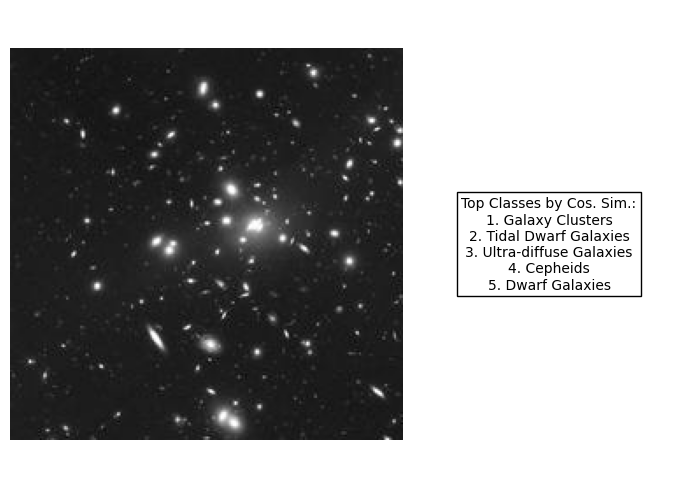

True abstract:
Category: COSMOLOGY.  We propose to study the physical nature of dark matter by using massive, merging clusters of galaxies. As shown with the Bullet Cluster {1E0657-56}, such massive well-measured systems are critical for our understanding of dark matter.  By more than doubling the number of clusters in the sample and obtaining systems at different observation angles, impact parameters, geometrical arrangements, and merger velocities, the systematic uncertainties in the dark matter cross section calculations can be improved substantially, allowing us to move from rough order of magnitude estimates to measurements with quantifiable uncertainties that can be compared usefully with the predictions from numerical simulations, and the constraints on alternate gravity models become unambiguous. Our proposed targets are three extraordinary, merging galaxy clusters with X-ray and optical offsets that are placed at ideal redshifts for such a study; A520, A1758N, and A2163. To pi

In [498]:
idx = 0

image_feat = model.get_image_features(inputs_images['pixel_values'][idx:idx + 1], params=restored_state.params);
text_feat = model.get_text_features(**claude_science_cat_inputs, params=restored_state.params)

# np.argsort((text_feat @ image_feat.T)[:, 0])[::-1]

cats = [claude_science_cat[i] for i in np.argsort(jax.vmap(cosine_similarity, in_axes=(0, None))(text_feat, image_feat[0]))[::-1]][:5]

display_content(images[idx], captions[idx], cats)

print("True abstract:")
print("===============")
print(captions[idx])

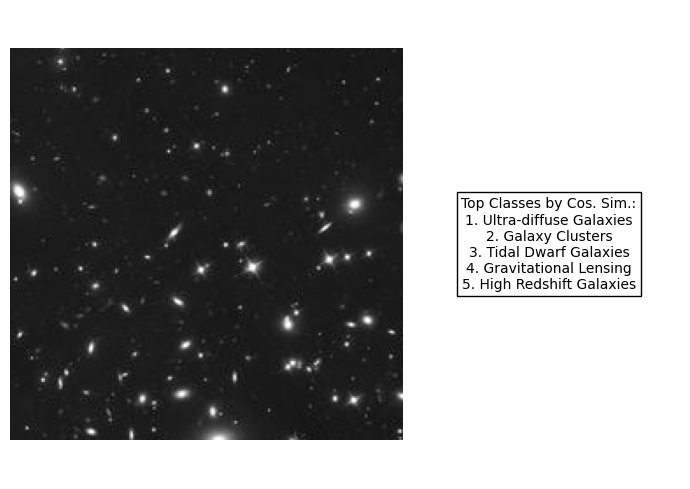

True abstract:
Category: COSMOLOGY.  We propose to study the physical nature of dark matter by using massive, merging clusters of galaxies. As shown with the Bullet Cluster {1E0657-56}, such massive well-measured systems are critical for our understanding of dark matter.  By more than doubling the number of clusters in the sample and obtaining systems at different observation angles, impact parameters, geometrical arrangements, and merger velocities, the systematic uncertainties in the dark matter cross section calculations can be improved substantially, allowing us to move from rough order of magnitude estimates to measurements with quantifiable uncertainties that can be compared usefully with the predictions from numerical simulations, and the constraints on alternate gravity models become unambiguous. Our proposed targets are three extraordinary, merging galaxy clusters with X-ray and optical offsets that are placed at ideal redshifts for such a study; A520, A1758N, and A2163. To pi

In [499]:
idx = 2

image_feat = model.get_image_features(inputs_images['pixel_values'][idx:idx + 1], params=restored_state.params);
text_feat = model.get_text_features(**claude_science_cat_inputs, params=restored_state.params)

cats = [claude_science_cat[i] for i in np.argsort(jax.vmap(cosine_similarity, in_axes=(0, None))(text_feat, image_feat[0]))[::-1]][:5]

display_content(images[idx], captions[idx], cats)

print("True abstract:")
print("===============")
print(captions[idx])

## Text-to-image retrieval

In [500]:
from tqdm.notebook import tqdm

In [501]:
from models.dataset_utils import make_dataloader, create_input_iter

ds = make_dataloader(files, batch_size=config.training.batch_size, seed=config.seed, split="val", shuffle=False)
batches = iter(ds)

In [502]:
import jax

image_feat_stack = []
images_stack = []
captions_stack = []

for (images, captions) in tqdm(batches, total=200):

    images = np.array(images)
    captions = captions.numpy().tolist()
    captions = [c.decode('utf-8') for c in captions]
    captions_stack += captions

    images_stack.append(images)
    
    images = center_crop(images, 224, 224)
    inputs_images = processor(text=captions, images=(images * 255.), return_tensors="np", padding="max_length", truncation=False, max_length=77)
    
    image_feat = jax.jit(model.get_image_features)(inputs_images['pixel_values'], params=restored_state.params);
    image_feat_stack.append(image_feat)

  0%|          | 0/200 [00:00<?, ?it/s]

In [503]:
# ["andromeda m31", "dwarf galaxies and globular clusters", "gravitational lensing", "ISM", "star formation", "AGN"]

In [601]:
query = "CIRCUMSTELLAR MATTER"
query_tokenized = tokenizer([query], padding="max_length", truncation=True, max_length=77, return_tensors="np")

text_feat = model.get_text_features(**query_tokenized, params=restored_state.params)

In [602]:
np.sort(jax.vmap(cosine_similarity, in_axes=(0, None))(np.vstack(image_feat_stack), text_feat[0]))

Array([0.1912062 , 0.20318615, 0.20463565, ..., 0.30474308, 0.30525365,
       0.30536348], dtype=float32)

In [603]:
sorted_idxs = np.argsort(jax.vmap(cosine_similarity, in_axes=(0, None))(np.vstack(image_feat_stack), text_feat[0]))[::-1]

In [604]:
def get_image_from_stack(images_stack, idx):
    return images_stack[idx // config.training.batch_size][idx % config.training.batch_size]

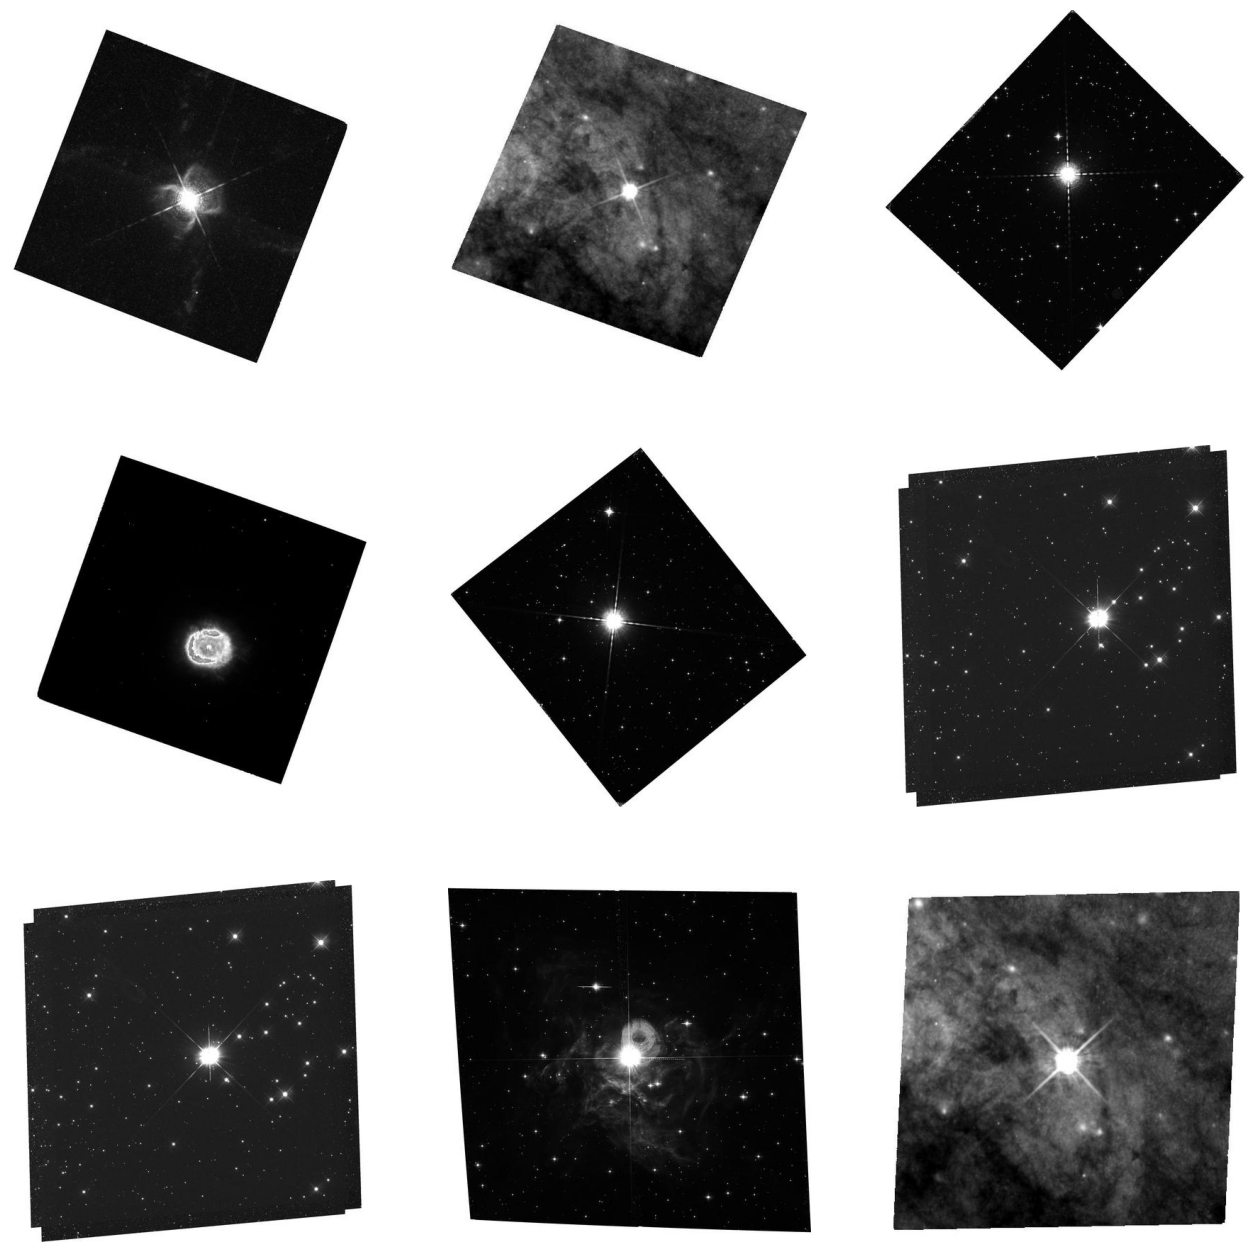

In [605]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 16))
grid_size = 3

# Loop through the images in the batch and plot them in a grid
for i in range(grid_size * grid_size):
    
    # Create a subplot for each image
    ax = plt.subplot(grid_size, grid_size, i + 1)
    
    # Display the image
    ax.imshow(get_image_from_stack(images_stack, sorted_idxs[i]), vmin=0, vmax=1)
    
    # Turn off axis numbers and ticks
    ax.axis('off')

# Display the full grid of images
plt.show()

In [606]:
[captions_stack[idx] for idx in sorted_idxs][:4]

['Category: Interstellar Medium.  We propose a "snapshot" emission-line imaging survey of a set of 30 very young planetary nebulae {PNe} selected on the basis of their very low excitation {VLE} characteristics, as evidenced by their very low O IIILambda5007, 4959 to H Alpha line flux ratios. These data will provide a unique, comprehensive dataset of images to address the issue of how AGB stars evolve into PNe. Planetary nebulae show a dazzling variety of structures not apparent in the circumstellar envelopes of the AGB stars from which they evolve. It is believed that the physical phenomena which shape the PNe occur early in thee formation history, involving the hydrodynamic interaction of one or more fast winds with the slower AGB mass-outflow. However, since the youngest PNe, which retain the clearest visible signatures of these phenomena, are very compact {<5\'\'}, ground-based observations provide very limited information on these objects. The WFPC2 on HST provides the necessary an

## Image-to-image retrieval

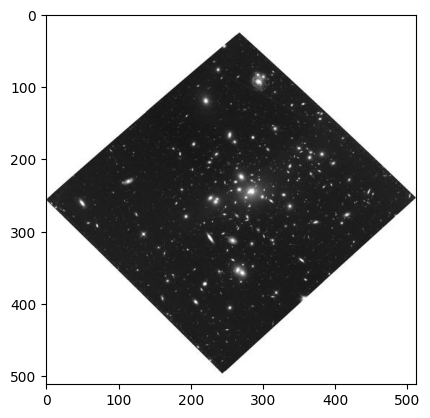

In [538]:
idx = 0

image_src_feat = np.vstack(image_feat_stack)[idx]
plt.imshow(get_image_from_stack(images_stack, idx))

In [539]:
sorted_idxs = np.argsort(jax.vmap(cosine_similarity, in_axes=(0, None))(np.vstack(image_feat_stack), image_src_feat))[::-1]

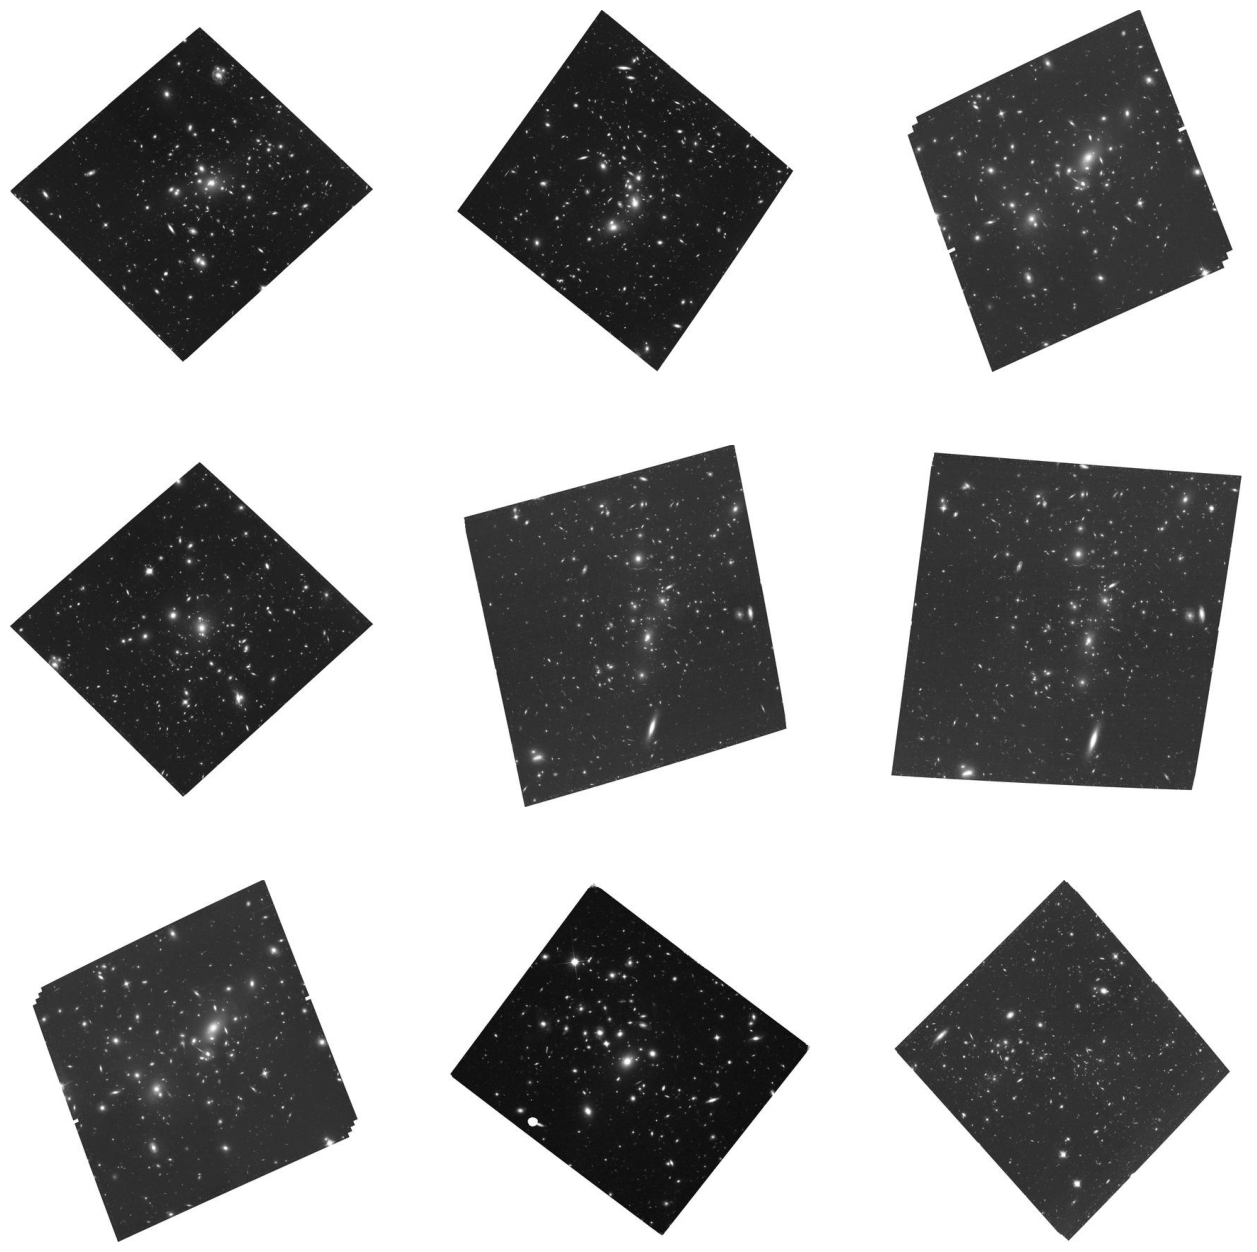

In [540]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 16))
grid_size = 3

# Loop through the images in the batch and plot them in a grid
for i in range(grid_size * grid_size):
    
    # Create a subplot for each image
    ax = plt.subplot(grid_size, grid_size, i + 1)
    
    # Display the image
    ax.imshow(get_image_from_stack(images_stack, sorted_idxs[i]), vmin=0, vmax=1)
    
    # Turn off axis numbers and ticks
    ax.axis('off')

# Display the full grid of images
plt.show()

## Viz embeddings

In [534]:
import jax.numpy as np
from sklearn.manifold import TSNE
X = np.vstack(image_feat_stack)[:6000]
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(X)

In [531]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_embedded = pca.fit_transform(np.vstack(image_feat_stack)[:])

In [532]:
pca.explained_variance_ratio_

array([0.19853434, 0.08827053], dtype=float32)

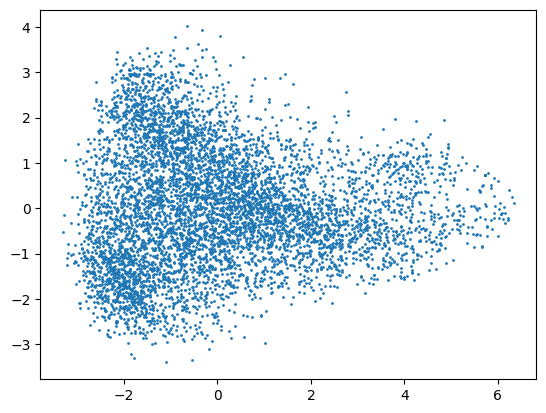

In [533]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], s=1)